# Problem set ztp370 - AppStat 2022/2023




### Author: 
- Eric Steen Ravn Bowman

### Date:    
- 03-01-2023 

***

As always we will include a collection of libraries (Standard)

In [16]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
from numpy.linalg import matrix_power                  # This is to raise matrices to powers
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats
import sympy as sp
sys.path.append('../External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

In [17]:
sys.path.append('../External_Functions')                 # Add the path to the folder with the functions
from MyFunctions import matplotlib_plotparameters, chi2_prob       # Import the function to set the plot parameters
matplotlib_plotparameters()                             # Set the plot parameters


In [18]:
r = np.random
r.seed(42)

## 3 - Simulation / Monte Carlo
3.1 -  $f(x) = C\cdot x^a\cdot sin(\pi x)$ for $x\in[0,1]$ and $a=3$.
 

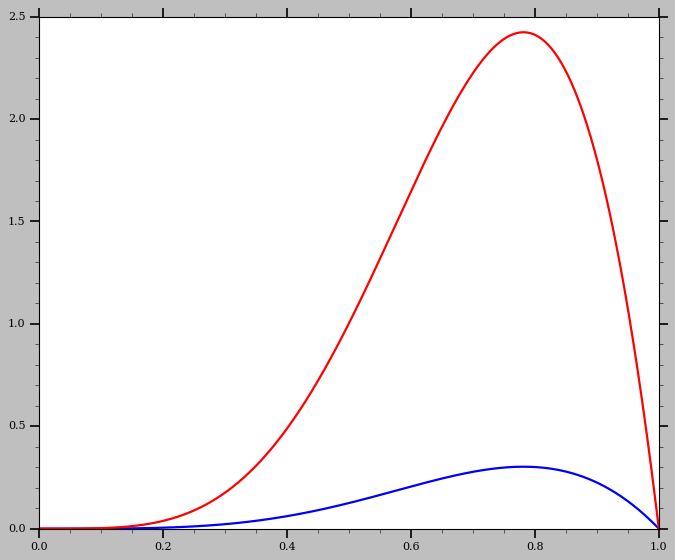

In [19]:
Npoints = 16200
Nbins = 100
linspace = np.linspace(0,1,Npoints)


def functi(x,C=1,a=3):
    return C*x**a*np.sin(np.pi*x)

plt.plot(linspace,functi(linspace))
func = functi(linspace,np.pi**3/(np.pi**2-6))
plt.plot(linspace,func,c='r')
# plt.plot(linspace,functi(linspace,np.pi**3/(np.pi**2-6),a=6.92))

In [20]:
# Which method(s) would I use to generate numbers according to the function?
# I since there are particalur limits then I will try to use the accept reject method

xmin, xmax = 0, 1
ymin, ymax = 0, 2.5
Ctrue=np.pi**3/(np.pi**2-6)
print(Ctrue)
bin_width = (xmax-xmin)/Nbins


xes = np.linspace(xmin, xmax, Npoints)

8.012776880130442


In [21]:
def function(x,a=3,C=Ctrue):
    return bin_width*Npoints*C*x**a*np.sin(np.pi*x)

In [22]:
f = np.zeros(Npoints)
Ntry=0
for i in range(Npoints):
    while True:
        Ntry += 1
        x = r.uniform(xmin, xmax)  
        y = r.uniform(ymin, ymax)        
        if (y < Ctrue*x**3*np.sin(np.pi*x)) :   # If the (x,y)-point fulfills the accept condition...
            break 
    f[i] = x

In [23]:
eff = Npoints/Ntry
print(f'The efficiency of the simulation is {eff:.4f}')
eff_error = np.sqrt((eff * (1-eff)) / Ntry)    # Error on efficiency (binomial)
print(f'The error on the efficiency is {eff_error:.3f}')


The efficiency of the simulation is 0.3989
The error on the efficiency is 0.002


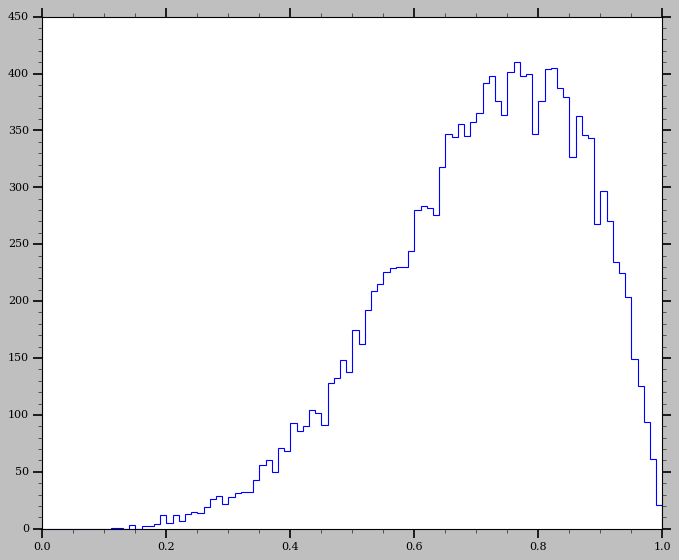

In [24]:
count,bins,_ = plt.hist(f, bins=Nbins, range=(xmin, xmax), histtype='step', label='Data')
mask = count > 0
count = count[mask]
error_count = np.sqrt(count)
center_bins = (bins[:-1] + bins[1:]) / 2
center_bins = center_bins[mask]

In [25]:
# Fit the simulated data with a the function
chi2_bin = Chi2Regression(function,center_bins,count,error_count) # Create the Chi2Regression object
chi2_bin.errordef = 1
minuit_bin = Minuit(chi2_bin, C=8, a=2.8 ) #   
minuit_bin.migrad()          # Perform the actual fit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 73.73                      │              Nfcn = 44               │
│ EDM = 8.71e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   3.071   │   0.031   │            │            │         │         │       │
│ 1 │ C    │   8.19    │   0.11    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        C │
├───┼───────────────────┤
│ a │ 0.000946  0.00289 │
│ C │  0.00289    0.013 │
└───┴───────────────────┘

In [32]:
afit= minuit_bin.values['a']
# relative error on a
aerror = minuit_bin.errors['a']
aer_rel = aerror/afit
print(f'The relative error on a is {aer_rel*100:.3f}%')
Cfit= minuit_bin.values['C']
print(f'The fitted value of a is {afit:.3f} +- {minuit_bin.errors["a"]:.3f}')
print(f'The fitted value of C is {Cfit:.3f} +- {minuit_bin.errors["C"]:.3f}')

#Calculate the chi2
chi2 = minuit_bin.fval
ndf = len(count) - 2
chi2_red = chi2/ndf
test = stats.chi2.sf(chi2, ndf)
print(f'{test}')

ki = chi2_prob(minuit_bin, ndf)



The relative error on a is 1.001%
The fitted value of a is 3.071 +- 0.031
The fitted value of C is 8.195 +- 0.114
0.8035658863027499


In [27]:
# be = plt.hist(f, bins=Nbins, range=(xmin,xmax), label='Simulated data')[0];
# area = be.sum()/Npoints
# print(f'The area under the histogram is {area:.3f}')

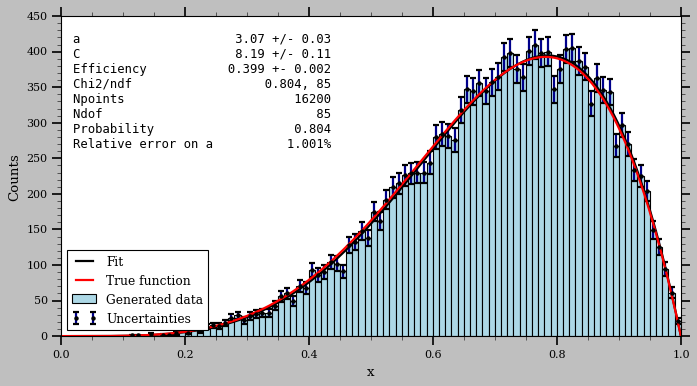

In [35]:
plt.figure(figsize=(10,5))
plt.hist(f, bins=Nbins, range=(xmin,xmax), label='Generated data', color='lightblue');
fit = function(xes, afit,Cfit)
plt.errorbar(center_bins, count, yerr=error_count, fmt='o', label='Uncertainties',ms=2, c='darkblue');
plt.plot(xes, fit, label='Fit', c='k');
plt.plot(xes, function(xes), label='True function', c='r');
d = {'a':[afit, minuit_bin.errors['a']], 'C':[Cfit, minuit_bin.errors['C']], 'Efficiency':f"{eff:.3f} +- {eff_error:.1}",
     'Chi2/ndf':f"{ki[0]:.3f}, {ki[1]:.0f}",
     'Npoints':f"{Npoints:d}",
     'Ndof':f"{ndf:d}",
     'Probability':f"{test:.3f}",'Relative error on a':f"{aer_rel*100:.3f}%"}

text = nice_string_output(d, extra_spacing=2, decimals=2)
add_text_to_ax(0.02, 0.95, text, ax=plt.gca(), fontsize=11)

plt.xlabel('x');
plt.ylabel('Counts');


plt.legend(loc='lower left');
plt.savefig('MC_Generated_Data.eps', bbox_inches='tight')

In [ ]:
# Npoints_array = np.array([ 1000, 10000, 100000, 1000000])
# f = np.zeros((Npoints,len(Npoints_array)))

# Ntrys=np.zeros(len(Npoints_array))
# for j in range(len(Npoints_array)):
#     for i in range(Npoints):
#         while True:
#             Ntrys[j] += 1
#             x = r.uniform(xmin, xmax)  
#             y = r.uniform(ymin, ymax)        
#             if (y < Ctrue*x**3*np.sin(np.pi*x)) :   # If the (x,y)-point fulfills the accept condition...
#                 break 
#         f[i][j] = x

In [ ]:

def get_data(N):
    count,bins,_ = plt.hist(f, bins=Nbins, range=(xmin, xmax), histtype='step', label='Data')
    mask = count > 0
    count = count[mask]
    error_count = np.sqrt(count)
    center_bins = (bins[:-1] + bins[1:]) / 2
    center_bins = center_bins[mask]
    return center_bins, count, error_count

def fitting(N):
    count,bins,_ = plt.hist(f, bins=Nbins, range=(xmin, xmax), histtype='step', label='Data')
    mask = count > 0
    count = count[mask]
    error_count = np.sqrt(count)
    center_bins = (bins[:-1] + bins[1:]) / 2
    center_bins = center_bins[mask]

    # Fit the simulated data with a the function
    chi2_bin = Chi2Regression(func,center_bins,count) # Create the Chi2Regression object
    chi2_bin.errordef = 1
    minuit_bin = Minuit(chi2_bin, C=8, a=2.8 ) #   
    minuit_bin.migrad()          # Perform the actual fit
    afit= minuit_bin.values['a']
    # relative error on a
    aerror = minuit_bin.errors['a']
    aer_rel = aerror/afit
    return aer_rel

# for i in range(len(Npoints_array)):
#     print(f'round {i+1} of {len(Npoints_array)}')
#     print(f'The relative error on a is {fitting(Npoints_array[i])*100:.3f}%')